In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.cluster import KMeans
import joblib

In [ ]:
df = pd.read_csv('/content/OCD Patient Dataset_ Demographics & Clinical Data.csv')

In [ ]:
df.head()

,Patient ID,Age,Gender,Ethnicity,Marital Status,Education Level,OCD Diagnosis Date,Duration of Symptoms (months),Previous Diagnoses,Family History of OCD,Obsession Type,Compulsion Type,Y-BOCS Score (Obsessions),Y-BOCS Score (Compulsions),Depression Diagnosis,Anxiety Diagnosis,Medications
0,1018,32,Female,African,Single,Some College,15-07-2016,203,MDD,No,Harm-related,Checking,17,10,Yes,Yes,SNRI
1,2406,69,Male,African,Divorced,Some College,28-04-2017,180,NaN,Yes,Harm-related,Washing,21,25,Yes,Yes,SSRI
2,1188,57,Male,Hispanic,Divorced,College Degree,02-02-2018,173,MDD,No,Contamination,Checking,3,4,No,No,Benzodiazepine
3,6200,27,Female,Hispanic,Married,College Degree,25-08-2014,126,PTSD,Yes,Symmetry,Washing,14,28,Yes,Yes,SSRI
4,5824,56,Female,Hispanic,Married,High School,20-02-2022,168,PTSD,Yes,Hoarding,Ordering,39,18,No,No,NaN


Variable description

● Patient ID: Unique identifier for each patient.

● Age: Age of the patient.

● Gender: Gender of the patient.

● Ethnicity: Ethnicity of the patient.

● Marital Status: Marital status of the patient.

● Education Level: Level of education attained by the patient.

● OCD Diagnosis Date: Date when OCD was diagnosed.

● Duration of Symptoms (months): Duration for which the patient has been experiencing symptoms.

● Previous Diagnoses: Any previous diagnoses before OCD.

● Family History of OCD:Whether the patient has a family history of OCD.

● Obsession Type: Type of obsessions experienced by the patient.

● Compulsion Type: Type of compulsions experienced by the patient.

● Y-BOCS Score (Obsessions): Y-BOCS score related to obsessions.

● Y-BOCS Score (Compulsions): Y-BOCS score related to compulsions.

● Depression Diagnosis: Whether the patient has been diagnosed with depression

● Anxiety Diagnosis: Whether the patient has been diagnosed with anxiety.

● Medications: Medications the patient is currently taking

In [ ]:
missing_data = df.isnull().sum()
print(missing_data)

Patient ID                         0
Age                                0
Gender                             0
Ethnicity                          0
Marital Status                     0
Education Level                    0
OCD Diagnosis Date                 0
Duration of Symptoms (months)      0
Previous Diagnoses               248
Family History of OCD              0
Obsession Type                     0
Compulsion Type                    0
Y-BOCS Score (Obsessions)          0
Y-BOCS Score (Compulsions)         0
Depression Diagnosis               0
Anxiety Diagnosis                  0
Medications                      386
dtype: int64


Data imputation

In [ ]:
import pandas as pd

# df is DataFrame,create a copy named df_clean
df_clean = df.copy()

# Add 'Unknown' to the categories of 'Previous Diagnoses' and 'Medications'
for col in ['Previous Diagnoses', 'Medications']:
    if df_clean[col].dtype.name == 'category':
        # Add 'Unknown' to the categories
        df_clean[col] = df_clean[col].cat.add_categories(['Unknown'])

    # Impute missing values with 'Unknown'
    df_clean[col] = df_clean[col].fillna('Unknown')

# Verify no missing values remain
print(df_clean[['Previous Diagnoses', 'Medications']].isnull().sum())

Previous Diagnoses    0
Medications           0
dtype: int64


Repeated values

In [ ]:
for column in df.columns:
    duplicates = df_clean[column][df_clean[column].duplicated()]
    if not duplicates.empty:
        print(f"Column '{column}' has repeated values.")
        print(duplicates.unique())
        print('-' * 50)
    else:
        print(f"Column '{column}' has all unique values.")


Column 'Patient ID' has repeated values.
[4884 1018 6919 5726 3727 2856 6053 8046 7679 7690 6855 9431 7430 4940
 6403 2946 9468 8827 7070 8798 7794 2101 8880 6778 3235 6153 2790 5738
 9877 1885 5176 6195 6239 1816 3516 6831 9995 5968 9755 3117 4500 5808
 7818 4830 2967 7123 8933 2215 5110 8097 4371 7301 9715 8117 2810 4315
 6251 8672 3681 4269 4568 7413 1190 2995 3955 5272 5759 5667 7622 2018
 2000 6166 9814 2903 6660 9256 6016 6228 5818 2613 1645 3273 8885 6673
 6047 5246 4571 6233 4298 8971 8335 6628 1815 2190 5423 7092 2249 8631
 5013]
--------------------------------------------------
Column 'Age' has repeated values.
[32 57 27 21 55 28 48 56 73 58 69 22 72 49 25 38 43 23 31 24 50 54 61 29
 47 66 46 26 70 19 35 62 51 71 60 75 59 67 42 52 39 45 40 53 68 37 18 33
 36 44 20 64 34 30 74 41 63 65]
--------------------------------------------------
Column 'Gender' has repeated values.
['Male' 'Female']
--------------------------------------------------
Column 'Ethnicity' has repeated val

Find duplicates

In [ ]:
# Find and display duplicate 'Patient ID' values
duplicate_patient_ids = df_clean[df_clean['Patient ID'].duplicated(keep=False)]
display(duplicate_patient_ids)

,Patient ID,Age,Gender,Ethnicity,Marital Status,Education Level,OCD Diagnosis Date,Duration of Symptoms (months),Previous Diagnoses,Family History of OCD,Obsession Type,Compulsion Type,Y-BOCS Score (Obsessions),Y-BOCS Score (Compulsions),Depression Diagnosis,Anxiety Diagnosis,Medications
0,1018,32,Female,African,Single,Some College,15-07-2016,203,MDD,No,Harm-related,Checking,17,10,Yes,Yes,SNRI
20,6778,27,Male,Asian,Single,Graduate Degree,06-11-2015,220,PTSD,Yes,Religious,Ordering,30,4,Yes,Yes,Benzodiazepine
31,6831,28,Male,Caucasian,Married,Some College,19-10-2021,58,Panic Disorder,Yes,Religious,Checking,27,4,No,No,Unknown
35,2995,73,Female,Caucasian,Married,Graduate Degree,27-12-2017,112,Panic Disorder,No,Religious,Washing,17,38,Yes,No,SNRI
40,9468,65,Female,Hispanic,Married,Graduate Degree,01-11-2018,134,PTSD,Yes,Symmetry,Washing,3,4,Yes,No,SSRI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,5423,37,Female,Caucasian,Single,Some College,24-01-2021,12,Unknown,No,Hoarding,Ordering,37,28,Yes,Yes,SNRI
1460,7092,20,Female,Hispanic,Married,College Degree,09-01-2021,192,Unknown,No,Hoarding,Praying,8,23,No,Yes,Unknown
1469,2249,56,Female,Caucasian,Divorced,College Degree,03-09-2018,206,GAD,Yes,Symmetry,Washing,16,29,Yes,No,Benzodiazepine
1470,8631,55,Male,Hispanic,Divorced,Some College,19-07-2020,155,Panic Disorder,No,Religious,Ordering,2,13,Yes,Yes,SSRI


In [ ]:
patient_details = df_clean[df_clean['Patient ID'] == 1018]
display(patient_details)

,Patient ID,Age,Gender,Ethnicity,Marital Status,Education Level,OCD Diagnosis Date,Duration of Symptoms (months),Previous Diagnoses,Family History of OCD,Obsession Type,Compulsion Type,Y-BOCS Score (Obsessions),Y-BOCS Score (Compulsions),Depression Diagnosis,Anxiety Diagnosis,Medications
0,1018,32,Female,African,Single,Some College,15-07-2016,203,MDD,No,Harm-related,Checking,17,10,Yes,Yes,SNRI
209,1018,73,Female,Caucasian,Single,College Degree,05-12-2015,150,Panic Disorder,Yes,Symmetry,Counting,9,15,No,No,SNRI


In [ ]:
df_clean = df_clean.drop(columns = ['Patient ID'])
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Age                            1500 non-null   int64 
 1   Gender                         1500 non-null   object
 2   Ethnicity                      1500 non-null   object
 3   Marital Status                 1500 non-null   object
 4   Education Level                1500 non-null   object
 5   OCD Diagnosis Date             1500 non-null   object
 6   Duration of Symptoms (months)  1500 non-null   int64 
 7   Previous Diagnoses             1500 non-null   object
 8   Family History of OCD          1500 non-null   object
 9   Obsession Type                 1500 non-null   object
 10  Compulsion Type                1500 non-null   object
 11  Y-BOCS Score (Obsessions)      1500 non-null   int64 
 12  Y-BOCS Score (Compulsions)     1500 non-null   int64 
 13  Dep

In [ ]:
object_cols = ['Gender', 'Ethnicity', 'Marital Status', 'Education Level','Previous Diagnoses',
               'Family History of OCD', 'Obsession Type', 'Compulsion Type',
               'Depression Diagnosis', 'Anxiety Diagnosis', 'Medications']

for col in object_cols:
    df_clean[col] = df_clean[col].astype('category')

df_clean['OCD Diagnosis Date'] = pd.to_datetime(df_clean['OCD Diagnosis Date'])

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Age                            1500 non-null   int64         
 1   Gender                         1500 non-null   category      
 2   Ethnicity                      1500 non-null   category      
 3   Marital Status                 1500 non-null   category      
 4   Education Level                1500 non-null   category      
 5   OCD Diagnosis Date             1500 non-null   datetime64[ns]
 6   Duration of Symptoms (months)  1500 non-null   int64         
 7   Previous Diagnoses             1500 non-null   category      
 8   Family History of OCD          1500 non-null   category      
 9   Obsession Type                 1500 non-null   category      
 10  Compulsion Type                1500 non-null   category      
 11  Y-BOCS Score (Obs

/tmp/ipython-input-456675430.py:8: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_clean['OCD Diagnosis Date'] = pd.to_datetime(df_clean['OCD Diagnosis Date'])


In [ ]:
selected_cols = [
    'Gender', 'Ethnicity', 'Marital Status', 'Education Level', 'Previous Diagnoses',
    'Family History of OCD', 'Obsession Type', 'Compulsion Type',
    'Depression Diagnosis', 'Anxiety Diagnosis', 'Medications'
]

for col in selected_cols:
    print(f"Unique values in '{col}':")
    print(df_clean[col].unique())
    print('-' * 150)


Unique values in 'Gender':
['Female', 'Male']
Categories (2, object): ['Female', 'Male']
------------------------------------------------------------------------------------------------------------------------------------------------------
Unique values in 'Ethnicity':
['African', 'Hispanic', 'Asian', 'Caucasian']
Categories (4, object): ['African', 'Asian', 'Caucasian', 'Hispanic']
------------------------------------------------------------------------------------------------------------------------------------------------------
Unique values in 'Marital Status':
['Single', 'Divorced', 'Married']
Categories (3, object): ['Divorced', 'Married', 'Single']
------------------------------------------------------------------------------------------------------------------------------------------------------
Unique values in 'Education Level':
['Some College', 'College Degree', 'High School', 'Graduate Degree']
Categories (4, object): ['College Degree', 'Graduate Degree', 'High School', 'So

Some of these variables are not known to people from other than medical background,so an explanation of these variables and attributes are given for clear understanding

Obsession type: It shows the kind of upsetting thoughts people with OCD often get stuck on,like fears or worries they can't shake,that lead them to do repetitive actions to feel better.


* Contamination: Fear of germs, dirt, or illness

  
*  Harm-related: Unwanted thoughts of causing injury to oneself or others



*   Hoarding: Difficulty discarding items, fear of losing something important

*  Religious: Intrusive blasphemous thoughts or fears of moral wrongdoing


*  Symmetry: Intense need for order or exactness


Compulsion type :It shows the kind of actions people with OCD feel they have to do,like cleaning, checking, or repeating things,to calm their anxious thoughts. These behaviors usually follow fixed patterns and feel hard to control.


* Washing: Excessive hand-washing or cleaning

* Checking: Repeatedly verifying things (e.g. locks, appliances)

*   Counting: Mental or physical counting routines
*   Praying: Ritualistic religious recitations

*  Ordering: Arranging items in a specific manner or alignment



Y-BOCS Score (Obsessions)
The Yale-Brown Obsessive Compulsive Scale (Y-BOCS) is a standard clinical tool to assess the severity of OCD symptoms. This column records numeric scores evaluating:



*   Time consumed by obsessive thoughts
*   Level of distress and interference
*   Resistance and control over the obsessions

Higher values (up to 40) suggest more intense obsession symptoms.

 Y-BOCS Score (Compulsions)
This score quantifies the severity of compulsive behaviors using the same scale and methodology as for obsessions. It accounts for:


*   Frequency and duration of compulsive acts
*   Degree of effort to resist
*   Level of control and impairment

Together, the obsession and compulsion scores provide a comprehensive metric of OCD severity.


Medications:

Benzodiazepine: A class of sedative drugs often used short-term to reduce intense anxiety. They act quickly but carry a risk of dependency, so doctors prescribe them cautiously.

SNRI (Serotonin-Norepinephrine Reuptake Inhibitor): Antidepressants that increase levels of serotonin and norepinephrine—two key mood-regulating chemicals. Helpful for treating depression and anxiety linked to OCD.

SSRI (Selective Serotonin Reuptake Inhibitor): The most commonly used medication for OCD. SSRIs boost serotonin levels in the brain and help reduce obsessions and compulsions over time.

Previous diagnostics:


*   GAD-	Generalized Anxiety Disorder—chronic worry and nervousness about everyday life
*   MDD-	Major Depressive Disorder—persistent sadness, hopelessness, and low energy

*   PTSD-	Post-Traumatic Stress Disorder—distressing symptoms following a traumatic event
*   Panic Disorder-	Sudden, intense episodes of fear and physical symptoms like heart palpitations


















Feature engineering

In [ ]:

df_clean['Total Y-BOCS Score'] = df_clean['Y-BOCS Score (Obsessions)'] + df_clean['Y-BOCS Score (Compulsions)']
df_clean['Age Group'] = pd.cut(df_clean['Age'], bins=[0, 30, 50, 100], labels=['Young', 'Middle', 'Older'])
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Age                            1500 non-null   int64         
 1   Gender                         1500 non-null   category      
 2   Ethnicity                      1500 non-null   category      
 3   Marital Status                 1500 non-null   category      
 4   Education Level                1500 non-null   category      
 5   OCD Diagnosis Date             1500 non-null   datetime64[ns]
 6   Duration of Symptoms (months)  1500 non-null   int64         
 7   Previous Diagnoses             1500 non-null   category      
 8   Family History of OCD          1500 non-null   category      
 9   Obsession Type                 1500 non-null   category      
 10  Compulsion Type                1500 non-null   category      
 11  Y-BOCS Score (Obs

Male female distribution

Gender
Male      753
Female    747
Name: count, dtype: int64


/tmp/ipython-input-3643158082.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.index, y=gender_counts.values, palette=gender_palette)


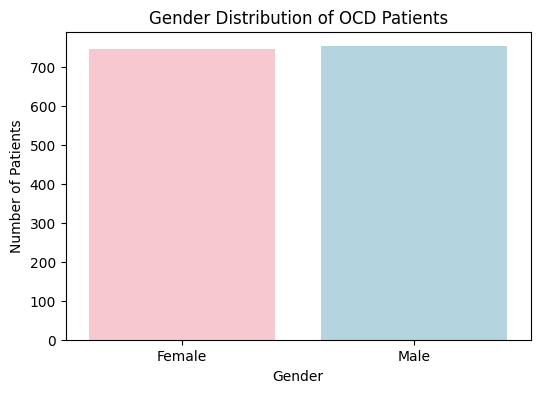

In [ ]:
gender_counts = df_clean['Gender'].value_counts()
print(gender_counts)
gender_palette = {'Male': 'lightblue', 'Female': 'pink'}

plt.figure(figsize=(6, 4))
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette=gender_palette)
plt.title('Gender Distribution of OCD Patients')
plt.xlabel('Gender')
plt.ylabel('Number of Patients')
plt.show()


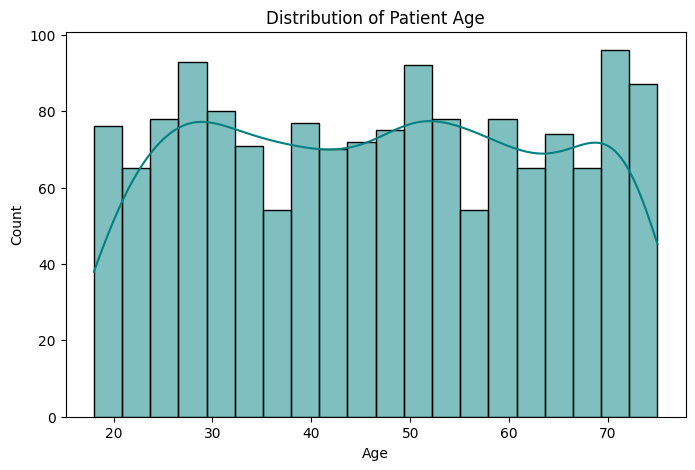

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df_clean['Age'], bins=20, kde=True, color='teal')
plt.title('Distribution of Patient Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Pie chart of each category of age group

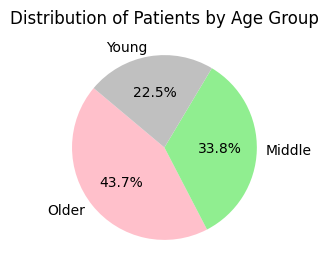

In [ ]:
# Count how many patients fall into each age group
age_counts = df_clean['Age Group'].value_counts()

# Create the pie chart
plt.figure(figsize=(3,3))
plt.pie(age_counts, labels=age_counts.index, autopct='%1.1f%%', startangle=140, colors=['pink', 'lightgreen', 'silver'])
plt.title('Distribution of Patients by Age Group')
plt.show()


Histogram


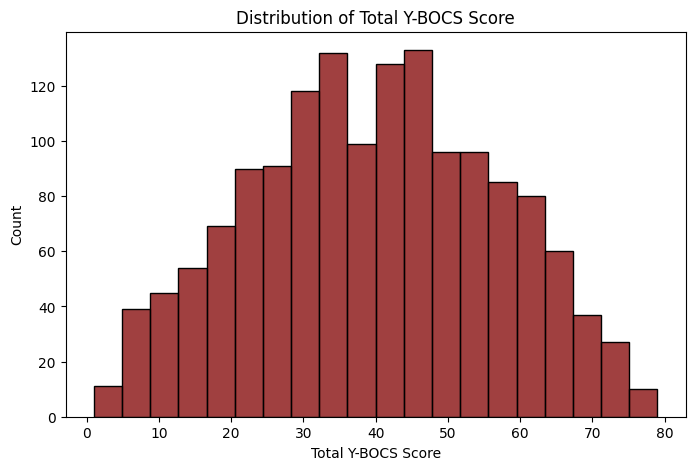

In [ ]:

plt.figure(figsize=(8, 5))
sns.histplot(df_clean['Total Y-BOCS Score'], bins=20, color='maroon')
plt.title('Distribution of Total Y-BOCS Score')
plt.xlabel('Total Y-BOCS Score')
plt.ylabel('Count')
plt.show()

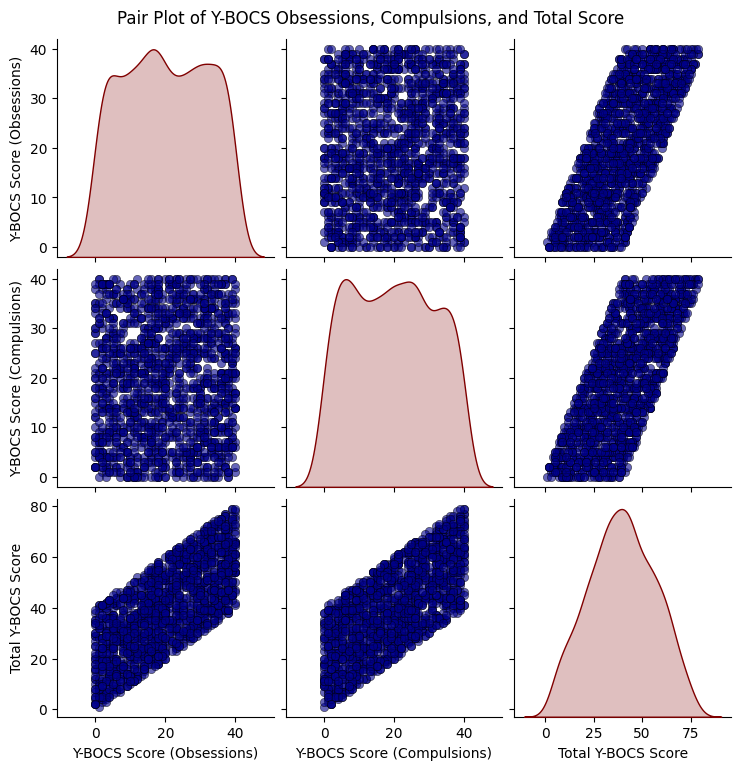

In [ ]:
# Select relevant columns
subset = df_clean[['Y-BOCS Score (Obsessions)', 'Y-BOCS Score (Compulsions)', 'Total Y-BOCS Score']]

# Customize pair plot
pair_grid = sns.pairplot(
    subset,
    diag_kind='kde',
    plot_kws={
        'alpha': 0.6,
        'color': 'darkblue',
        'edgecolor': 'black'
    },
    diag_kws={
        'fill': True,
        'color': 'maroon'
    }
)
pair_grid.fig.suptitle('Pair Plot of Y-BOCS Obsessions, Compulsions, and Total Score', y=1.02)
plt.show()

In [ ]:
# Extract year
df_clean['Diagnosis Year'] = df_clean['OCD Diagnosis Date'].dt.year
# Calculate frequency of diagnoses per year
year_counts = df_clean['Diagnosis Year'].value_counts().sort_index()
print("Diagnosis Year Distribution:")
print(year_counts)

# Identify the most common year
most_common_year = year_counts.idxmax()
most_common_count = year_counts.max()
print(f"\nMost Common Year for OCD Diagnoses: {most_common_year} with {most_common_count} cases")
# Interactive bar plot with Plotly
fig = px.bar(x=year_counts.index, y=year_counts.values,
             title='Frequency of OCD Diagnoses by Year',
             labels={'x': 'Diagnosis Year', 'y': 'Number of Diagnoses'},
             color=year_counts.index, color_continuous_scale='Viridis')
fig.update_layout(showlegend=False)
fig.show()

Diagnosis Year Distribution:
Diagnosis Year
2013     18
2014    157
2015    170
2016    163
2017    163
2018    204
2019    167
2020    169
2021    150
2022    139
Name: count, dtype: int64

Most Common Year for OCD Diagnoses: 2018 with 204 cases


Ethnicity

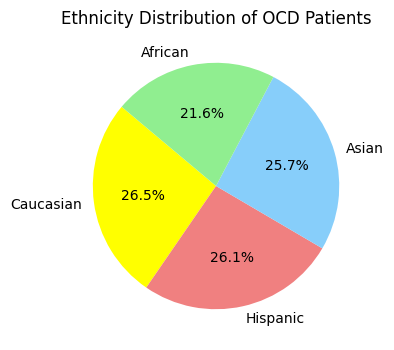

In [ ]:

# Count ethnicity values
ethnicity_counts = df_clean['Ethnicity'].value_counts()

# Plot pie chart
plt.figure(figsize=(4,4))
plt.pie(ethnicity_counts, labels=ethnicity_counts.index, autopct='%1.1f%%', startangle=140,
        colors=['yellow', 'lightcoral', 'lightskyblue', 'lightgreen'])
plt.title('Ethnicity Distribution of OCD Patients')
plt.show()


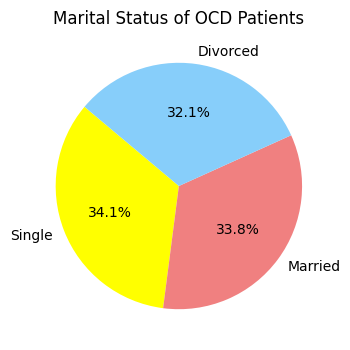

In [ ]:

marital_stats_count = df_clean['Marital Status'].value_counts()

# Plot pie chart
plt.figure(figsize=(4,4))
plt.pie(marital_stats_count, labels=marital_stats_count.index, autopct='%1.1f%%', startangle=140,
        colors=['yellow', 'lightcoral', 'lightskyblue', 'lightgreen'])
plt.title('Marital Status of OCD Patients')
plt.show()

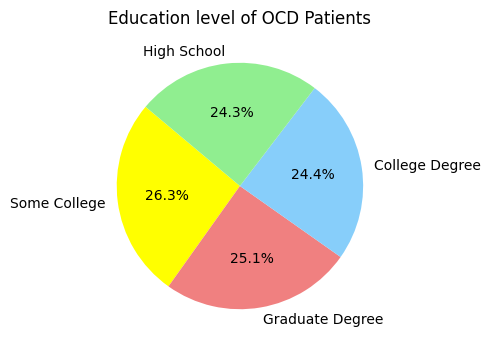

In [ ]:
# Count ethnicity values
edu_level_count = df_clean['Education Level'].value_counts()

# Plot pie chart
plt.figure(figsize=(4,4))
plt.pie(edu_level_count, labels=edu_level_count.index, autopct='%1.1f%%', startangle=140,
        colors=['yellow', 'lightcoral', 'lightskyblue', 'lightgreen'])
plt.title('Education level of OCD Patients')
plt.show()

Bivariate

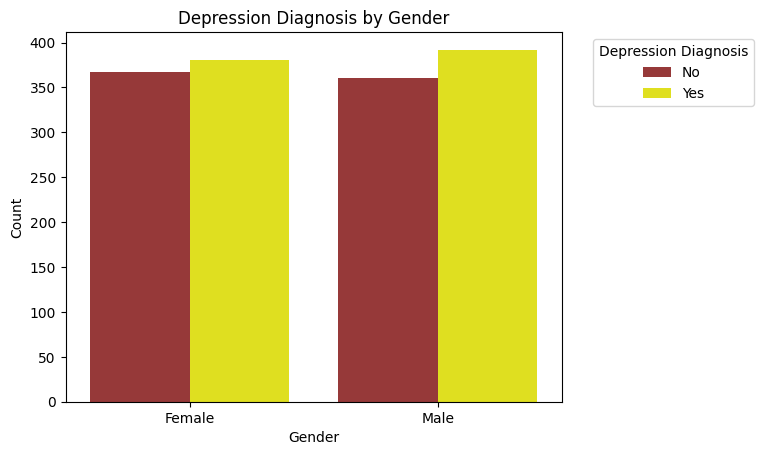

In [ ]:
contingency_table = pd.crosstab(df_clean['Gender'], df_clean['Depression Diagnosis'], margins=True)
sns.countplot(x='Gender', hue='Depression Diagnosis', data=df_clean, palette={'Yes':'yellow', 'No':'brown'},legend= True)
plt.title('Depression Diagnosis by Gender')
plt.legend(title='Depression Diagnosis', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

In [ ]:
from scipy.stats import chi2_contingency

# Null Hypothesis: No association between gender and depression
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square = {chi2:.2f}, p = {p:.3f}")
print("Expected frequencies (no association):\n", expected)

Chi-square = 0.21, p = 0.995
Expected frequencies (no association):
 [[ 362.544  384.456  747.   ]
 [ 365.456  387.544  753.   ]
 [ 728.     772.    1500.   ]]


Correlation analysis

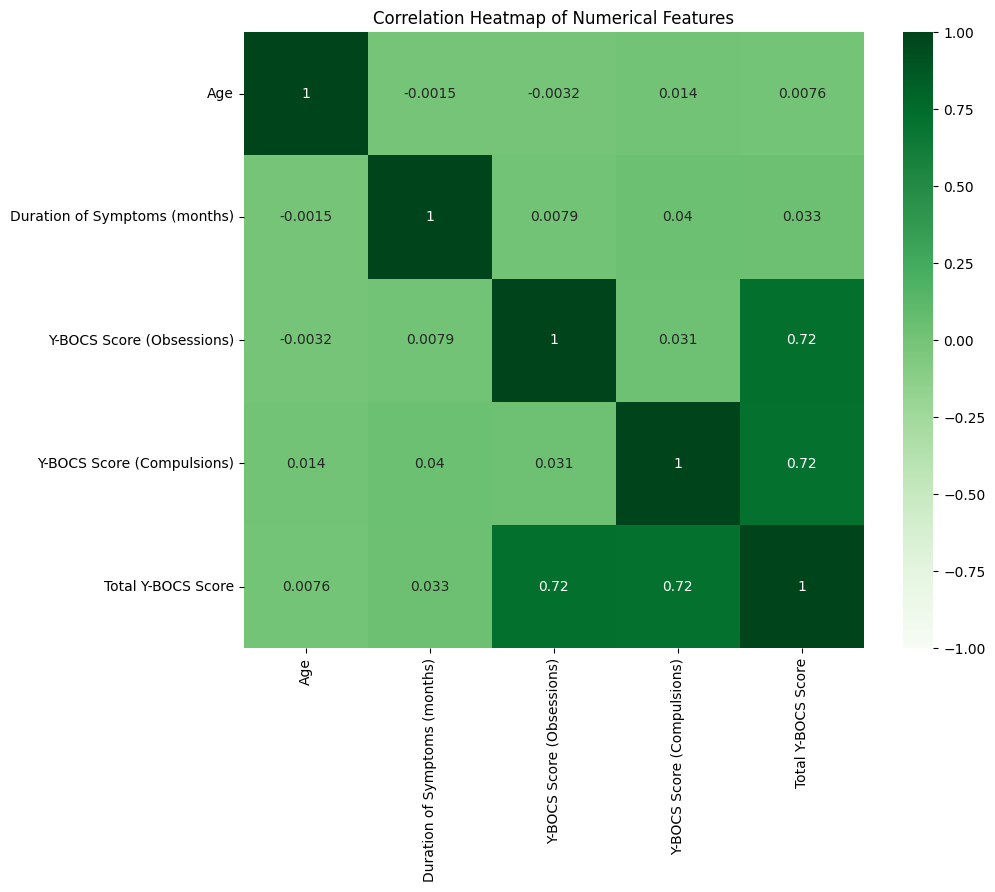

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = df_clean[['Age', 'Duration of Symptoms (months)', 'Y-BOCS Score (Obsessions)',
                  'Y-BOCS Score (Compulsions)', 'Total Y-BOCS Score']].corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Greens', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

Exploring how categorical variables (Gender, Ethnicity, Obsession Type, Compulsion Type) interact with numerical outcomes (Total Y-BOCS Score).

Apply PCA (Principal Component Analysis) on numerical and encoded categorical features to visualize clusters.

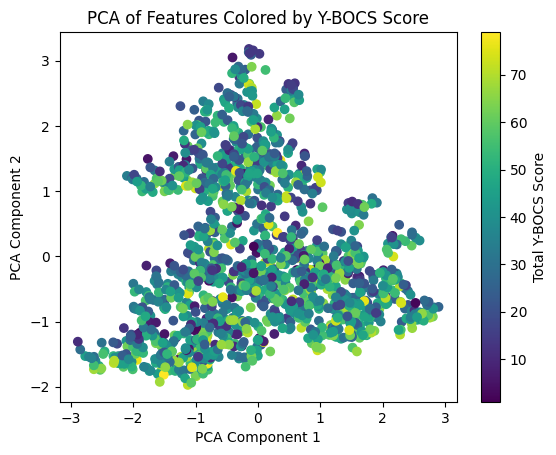

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# Encode categorical variables
df_encoded = pd.get_dummies(df[['Gender', 'Ethnicity', 'Obsession Type', 'Compulsion Type']], drop_first=True)
# Combine with numerical features
X = pd.concat([df_clean[['Age', 'Duration of Symptoms (months)', 'Total Y-BOCS Score']], df_encoded], axis=1)
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_clean['Total Y-BOCS Score'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Total Y-BOCS Score')
plt.title('PCA of Features Colored by Y-BOCS Score')
plt.show()


# Disease Prediction Pipeline


One-hot encoding

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Define numerical and categorical columns
num_cols = ['Age', 'Duration of Symptoms (months)', 'Y-BOCS Score (Obsessions)']
cat_cols = ['Gender', 'Ethnicity', 'Obsession Type', 'Compulsion Type', 'Depression Diagnosis']

# One-Hot Encoding
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_cat = ohe.fit_transform(df_clean[cat_cols])
X_cat_df = pd.DataFrame(X_cat, columns=ohe.get_feature_names_out(cat_cols))

# Combine with numerical columns
X_num = df_clean[num_cols]
X = pd.concat([X_num.reset_index(drop=True), X_cat_df.reset_index(drop=True)], axis=1)

# Target variable
y = df_clean['Total Y-BOCS Score']

# Verify shapes
print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)

Feature matrix shape: (1500, 16)
Target shape: (1500,)


Feature Scaling
Standardize the numerical features to ensure consistent scales for modeling.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Verify scaling
print(X[num_cols].describe())

                Age  Duration of Symptoms (months)  Y-BOCS Score (Obsessions)
count  1.500000e+03                   1.500000e+03               1.500000e+03
mean  -1.657933e-16                  -1.539509e-17               1.421085e-16
std    1.000334e+00                   1.000334e+00               1.000334e+00
min   -1.710659e+00                  -1.717745e+00              -1.696117e+00
25%   -8.785491e-01                  -8.569828e-01              -8.500888e-01
50%    1.299676e-02                  -1.106129e-02              -4.060934e-03
75%    8.451062e-01                   8.348602e-01               9.265697e-01
max    1.677216e+00                   1.754985e+00               1.687995e+00


Feature Selection



Use Recursive Feature Elimination (RFE) with a Random Forest Regressor to select the top 10 features.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

# Initialize model for RFE
rf = RandomForestRegressor(random_state=42)

# Apply RFE
rfe = RFE(estimator=rf, n_features_to_select=10)
rfe.fit(X, y)

# Get selected features
selected_features = X.columns[rfe.support_]
print("Selected Features:", selected_features)

# Update X
X_selected = X[selected_features]

Selected Features: Index(['Age', 'Duration of Symptoms (months)', 'Y-BOCS Score (Obsessions)',
       'Gender_Male', 'Ethnicity_Caucasian', 'Ethnicity_Hispanic',
       'Obsession Type_Harm-related', 'Obsession Type_Religious',
       'Obsession Type_Symmetry', 'Depression Diagnosis_Yes'],
      dtype='object')


Create a pipeline to combine preprocessing and modeling, using XGBoost for regression.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ])

# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])

# Split data
X = df_clean[num_cols + cat_cols]
y = df_clean['Total Y-BOCS Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

R² Score (Test): 0.9847
MAE (Test): 1.6054


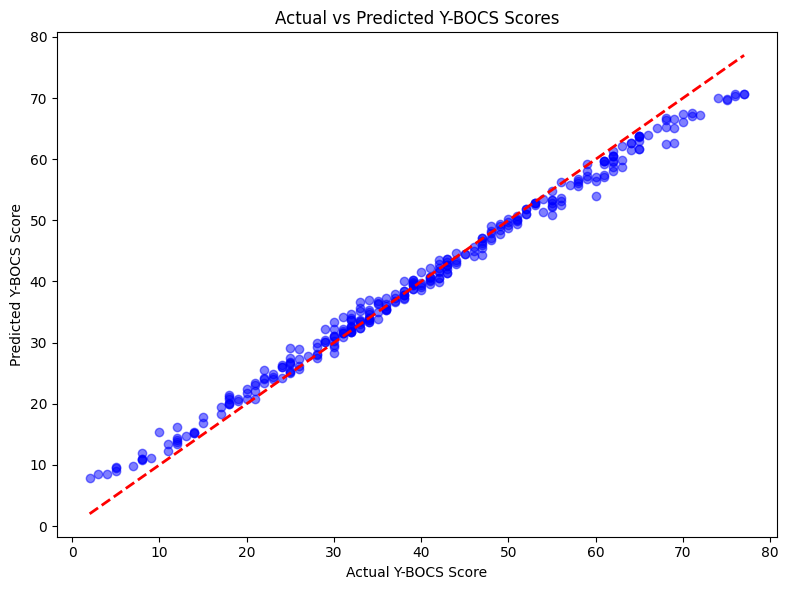

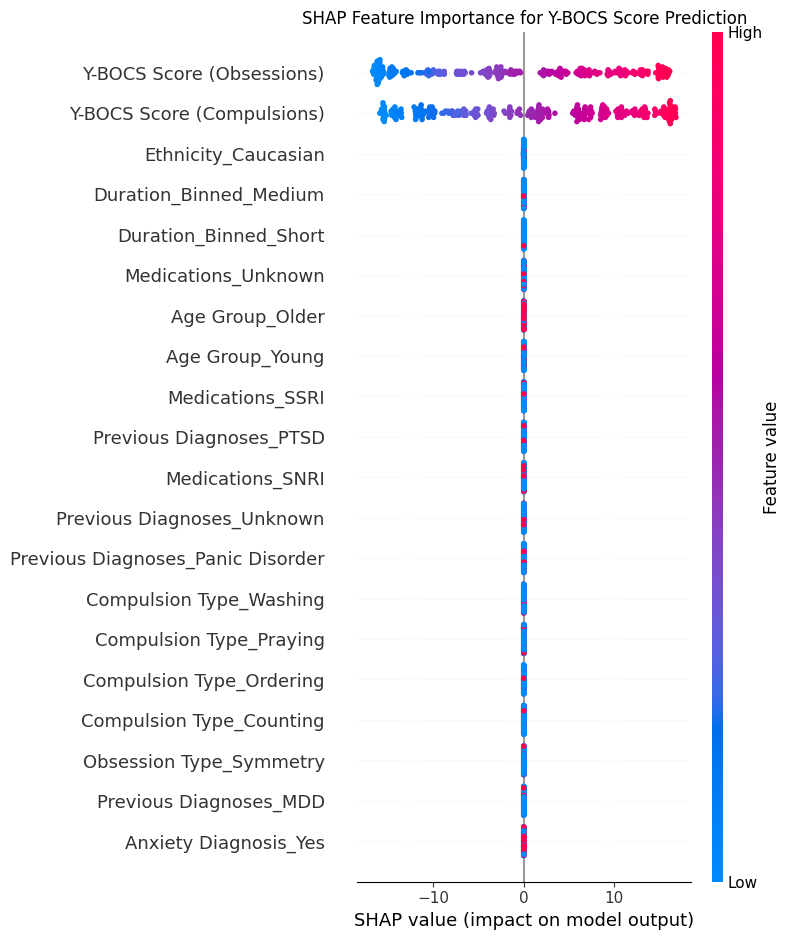

Cluster Distribution:
Cluster
0    531
1    502
2    467
Name: count, dtype: int64
Cluster Statistics:
         Total Y-BOCS Score        Age  Duration of Symptoms (months)  \
Cluster                                                                 
0                 38.962335  29.020716                     127.935970   
1                 40.511952  58.424303                     178.260956   
2                 39.582441  54.460385                      53.955032   

         Y-BOCS Score (Obsessions)  Y-BOCS Score (Compulsions)  
Cluster                                                         
0                        19.807910                   19.154426  
1                        20.314741                   20.197211  
2                        20.034261                   19.548180  


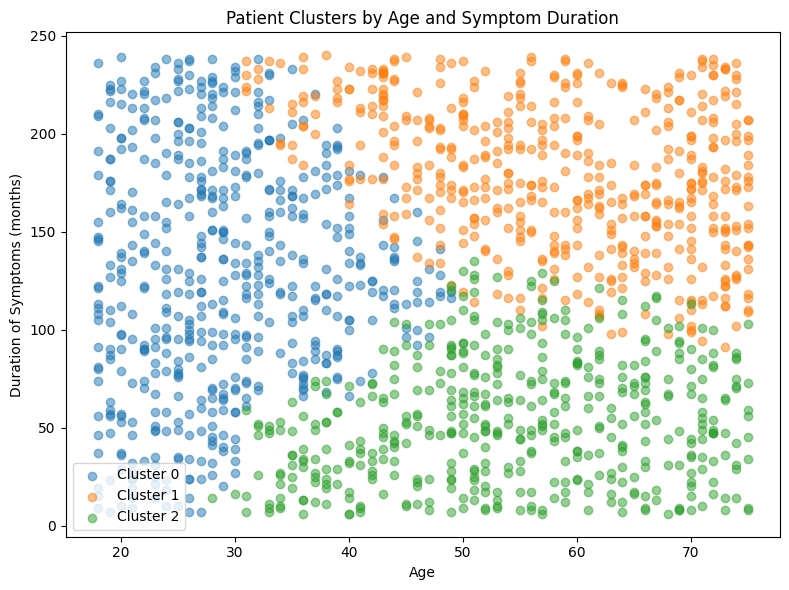

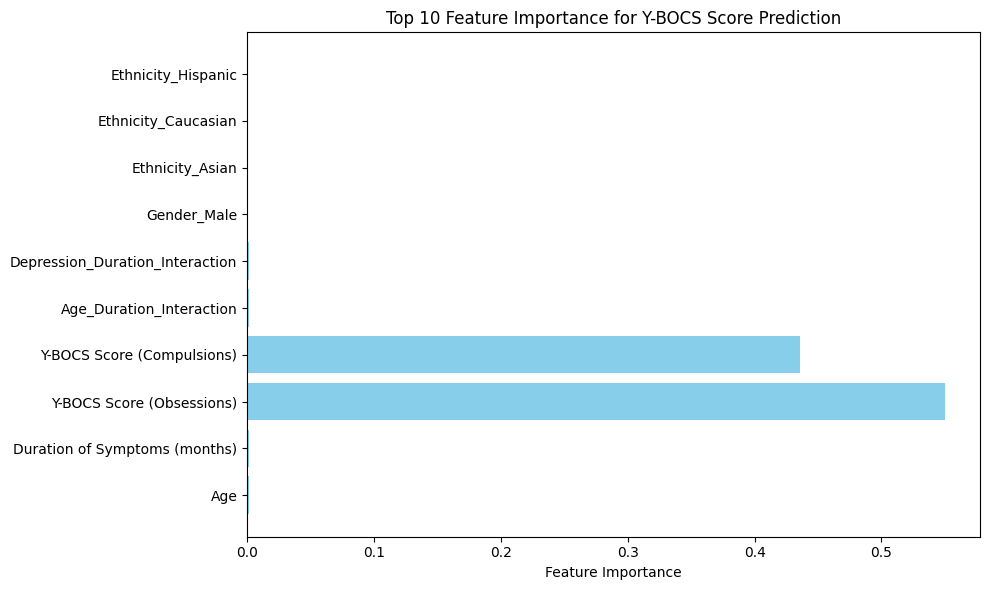

Models saved as 'ocd_model.pkl' and 'kmeans_model.pkl'
Plots saved as 'prediction_plot.png', 'shap_plot.png', 'cluster_plot.png', and 'feature_importance.png'


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.cluster import KMeans
import joblib

# Feature engineering
df_clean = df_clean.copy()
df_clean['Age_Duration_Interaction'] = df_clean['Age'] * df_clean['Duration of Symptoms (months)']
df_clean['Depression_Duration_Interaction'] = df_clean['Depression Diagnosis'].map({'Yes': 1, 'No': 0}).astype('int64') * df_clean['Duration of Symptoms (months)']
df_clean['Duration_Binned'] = pd.cut(df_clean['Duration of Symptoms (months)'], bins=[0, 12, 60, 240], labels=['Short', 'Medium', 'Long'])

# Define columns
num_cols = ['Age', 'Duration of Symptoms (months)', 'Y-BOCS Score (Obsessions)', 'Y-BOCS Score (Compulsions)', 'Age_Duration_Interaction', 'Depression_Duration_Interaction']
cat_cols = ['Gender', 'Ethnicity', 'Marital Status', 'Education Level', 'Family History of OCD',
            'Obsession Type', 'Compulsion Type', 'Depression Diagnosis', 'Anxiety Diagnosis',
            'Previous Diagnoses', 'Medications', 'Age Group', 'Duration_Binned']

# Step 1: Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat_cols)
    ])

# Step 2: Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.7, reg_lambda=1.0, random_state=42))
])

# Step 3: Split data
X = df_clean[num_cols + cat_cols]
y = df_clean['Total Y-BOCS Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train and evaluate model
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"R² Score (Test): {r2:.4f}")
print(f"MAE (Test): {mae:.4f}")

# Visualize predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Y-BOCS Score')
plt.ylabel('Predicted Y-BOCS Score')
plt.title('Actual vs Predicted Y-BOCS Scores')
plt.tight_layout()
plt.savefig('prediction_plot.png', bbox_inches='tight')
plt.show()

# Step 5: SHAP explanations
X_transformed = pipeline.named_steps['preprocessor'].transform(X_test)
feature_names = num_cols + list(pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_cols))
explainer = shap.TreeExplainer(pipeline.named_steps['regressor'])
shap_values = explainer.shap_values(X_transformed)
shap.summary_plot(shap_values, X_transformed, feature_names=feature_names, show=False)
plt.title('SHAP Feature Importance for Y-BOCS Score Prediction')
plt.tight_layout()
plt.savefig('shap_plot.png', bbox_inches='tight')
plt.show()

# Step 6: Clustering for patient segmentation
kmeans = KMeans(n_clusters=3, random_state=42)
X_all_transformed = pipeline.named_steps['preprocessor'].transform(X)
clusters = kmeans.fit_predict(X_all_transformed)
df_clean['Cluster'] = clusters
print("Cluster Distribution:")
print(df_clean['Cluster'].value_counts())
print("Cluster Statistics:")
print(df_clean.groupby('Cluster')[['Total Y-BOCS Score', 'Age', 'Duration of Symptoms (months)', 'Y-BOCS Score (Obsessions)', 'Y-BOCS Score (Compulsions)']].mean())

# Visualize clusters
plt.figure(figsize=(8, 6))
for cluster in range(3):
    mask = df_clean['Cluster'] == cluster
    plt.scatter(df_clean[mask]['Age'], df_clean[mask]['Duration of Symptoms (months)'],
                label=f'Cluster {cluster}', alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Duration of Symptoms (months)')
plt.title('Patient Clusters by Age and Symptom Duration')
plt.legend()
plt.tight_layout()
plt.savefig('cluster_plot.png', bbox_inches='tight')
plt.show()

# Step 7: Feature importance with Matplotlib
rf = RandomForestRegressor(random_state=42)
rf.fit(X_transformed, y_test)
importances = rf.feature_importances_[:10]
top_features = feature_names[:10]
plt.figure(figsize=(10, 6))
plt.barh(top_features, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importance for Y-BOCS Score Prediction')
plt.tight_layout()
plt.savefig('feature_importance.png', bbox_inches='tight')
plt.show()

# Step 8: Save models and plots
joblib.dump(pipeline, 'ocd_model.pkl')
joblib.dump(kmeans, 'kmeans_model.pkl')
print("Models saved as 'ocd_model.pkl' and 'kmeans_model.pkl'")
print("Plots saved as 'prediction_plot.png', 'shap_plot.png', 'cluster_plot.png', and 'feature_importance.png'")


# Key insights

OCD symptom severity is strongly predicted by Y-BOCS sub-scores and symptom duration.

Demographic factors like age and ethnicity have minimal linear impact but may interact in non-linear ways.

Machine learning models can achieve high accuracy in predicting clinical scores, aiding early intervention.

Patient clustering reveals distinct subgroups, supporting tailored therapeutic approaches.